## Imports

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ta.volatility import BollingerBands, AverageTrueRange
from ta.momentum import RSIIndicator
from ta.trend import EMAIndicator

In [2]:
class Strategy2:
    def __init__(self, stock_symbol, start_date, end_date, bb_window, bb_sd, rsi_window, atr_window, ema_lr_window, ema_sr_window):
        self.stock_symbol = stock_symbol
        self.start_date = start_date
        self.end_date = end_date
        self.stock_data = self.get_stock_data() # Retrieve historical stock data
        self.calculate_bollinger_bands(window=bb_window, std_dev=bb_sd) # Calculate Bollinger Bands 
        self.calculate_RSI(window=rsi_window) # Calculate RSI 
        self.calculate_ATR(window=atr_window) # Calculate ATR
        self.calculate_EMA(lr_window=ema_lr_window, sr_window=ema_sr_window)

    def get_stock_data(self):
        df = pd.DataFrame()
        ticker_data = yf.download(self.stock_symbol, self.start_date, self.end_date).reset_index()
        df['Date'] = ticker_data['Date']
        df[f'{self.stock_symbol}_Adj_Close'] = ticker_data['Adj Close']
        df[f'{self.stock_symbol}_Returns'] = df[f'{self.stock_symbol}_Adj_Close'].pct_change()
        df[f'{self.stock_symbol}_High'] = ticker_data['High']
        df[f'{self.stock_symbol}_Low'] = ticker_data['Low']
        return df

    def calculate_bollinger_bands(self, window, std_dev):
        bb_indicator = BollingerBands(close=self.stock_data[f'{self.stock_symbol}_Adj_Close'], window=window, window_dev=std_dev)
        self.stock_data['Upper_Band'] = bb_indicator.bollinger_hband()
        self.stock_data['Lower_Band'] = bb_indicator.bollinger_lband()
        self.stock_data['Moving_Average'] = bb_indicator.bollinger_mavg()

    def calculate_RSI(self, window):
        rsi_indicator = RSIIndicator(close = self.stock_data[f'{self.stock_symbol}_Adj_Close'], window=window, fillna= False)
        self.stock_data['RSI'] = rsi_indicator.rsi()

    def calculate_ATR(self, window):
        atr_indicator = AverageTrueRange(high=self.stock_data[f'{self.stock_symbol}_High'], low=self.stock_data[f'{self.stock_symbol}_Low'], close=self.stock_data[f'{self.stock_symbol}_Adj_Close'], window=window)
        self.stock_data['ATR'] = atr_indicator.average_true_range()

    def calculate_EMA(self, lr_window, sr_window):
        ema_lr_indicator = EMAIndicator(close=self.stock_data[f'{self.stock_symbol}_Adj_Close'], window=lr_window)
        ema_sr_indicator = EMAIndicator(close=self.stock_data[f'{self.stock_symbol}_Adj_Close'], window=sr_window)
        self.stock_data['LR_EMA'] = ema_lr_indicator.ema_indicator()
        self.stock_data['SR_EMA'] = ema_sr_indicator.ema_indicator()

    def generate_signals_positions(self):
        self.stock_data['Signal'] = 0
        self.stock_data['Position'] = 0

        # Define an ATR threshold for volatility filter
        atr_threshold = self.stock_data['ATR'].quantile(0.75)

        # Set the first day's signal to buy (long position)
        self.stock_data.loc[0, 'Signal'] = 1  # Instantly buy on the first day

        # Initialize counters to track consecutive long and short signals
        consecutive_long = 0
        consecutive_short = 0

        # Loop through the stock data starting from the second day
        for i in range(1, len(self.stock_data)):
            price = self.stock_data.loc[i, f'{self.stock_symbol}_Adj_Close']
            upper_band = self.stock_data.loc[i, 'Upper_Band']
            lower_band = self.stock_data.loc[i, 'Lower_Band']
            rsi = self.stock_data.loc[i, 'RSI']
            atr = self.stock_data.loc[i, 'ATR']
            lr_ema = self.stock_data.loc[i, 'LR_EMA']
            sr_ema = self.stock_data.loc[i, 'SR_EMA']

            # Get previous signal 
            previous_signal = self.stock_data.loc[i - 1, 'Signal']

            # # ATR as primary signal
            # if atr > atr_threshold:
            #     # Bollinger Bands and RSI as indicator of overbought and oversold conditions
            #     if price < lower_band and rsi < 30:
            #         self.stock_data.loc[i, 'Signal'] = 1
            #         consecutive_long = consecutive_short = 0
            #     elif price > upper_band and rsi > 70:
            #         self.stock_data.loc[i, 'Signal'] = -1
            #         consecutive_long = consecutive_short = 0
            #     else:
            #         # No confirmation from technical indicators, do not change from previous signal
            #         self.stock_data.loc[i, 'Signal'] = previous_signal
            #         consecutive_long = consecutive_short = 0

            # # Long Condition using EMA, Bollinger Bands and RSI
            # elif sr_ema > lr_ema and (price < lower_band or rsi < 30):
            #     self.stock_data.loc[i, 'Signal'] = 1
            #     consecutive_long = consecutive_short = 0 
            # # Short Condition using EMA, Bollinger Bands and RSI
            # elif sr_ema < lr_ema and (price > upper_band or rsi > 70):
            #     self.stock_data.loc[i, 'Signal'] = -1
            #     consecutive_long = consecutive_short = 0 

            # # Consecutive EMA signals to determine long or short
            # elif consecutive_long >= 5 and previous_signal != 1:
            #     self.stock_data.loc[i, 'Signal'] = 1
            #     consecutive_long = consecutive_short = 0
            # elif consecutive_short == 5 and previous_signal != -1:
            #     self.stock_data.loc[i, 'Signal'] = -1
            #     consecutive_long = consecutive_short = 0

            # # Check for consecutive signals from EMA
            # elif sr_ema > lr_ema:
            #     self.stock_data.loc[i, 'Signal'] = previous_signal
            #     consecutive_long += 1
            #     consecutive_short = 0 
            # elif sr_ema < lr_ema:
            #     self.stock_data.loc[i, 'Signal'] = previous_signal
            #     consecutive_short += 1
            #     consecutive_long = 0

            # else:
            #     # No confirmation from technical indicators, do not change from previous signal
            #     self.stock_data.loc[i, 'Signal'] = previous_signal
            #     consecutive_long = consecutive_short = 0 
            
            if price < lower_band and rsi < 30:
                self.stock_data.loc[i, 'Signal'] = 1
                consecutive_long = consecutive_short = 0
            # Sell when price is above the upper band, RSI indicates overbought (>70) and ATR > ATR_threshold
            elif price > upper_band and rsi > 70 and atr > atr_threshold:
                self.stock_data.loc[i, 'Signal'] = -1
                consecutive_long = consecutive_short = 0
            # Long Condition using EMA, Bollinger Bands and RSI
            elif sr_ema > lr_ema and (price > upper_band or rsi > 70) and atr < atr_threshold:
                self.stock_data.loc[i, 'Signal'] = 1
                consecutive_long = consecutive_short = 0
            # Short Condition using EMA, Bollinger Bands and RSI
            elif sr_ema < lr_ema and (price < lower_band or rsi < 30) and atr < atr_threshold:
                self.stock_data.loc[i, 'Signal'] = -1
                consecutive_long = consecutive_short = 0

            # Consecutive EMA signals to determine long or short
            elif sr_ema > lr_ema and 35 < rsi < 65 and atr < atr_threshold:
                self.stock_data.loc[i, 'Signal'] = 1
                consecutive_long = consecutive_short = 0
            elif sr_ema < lr_ema and 35 < rsi < 65 and atr < atr_threshold:
                self.stock_data.loc[i, 'Signal'] = -1
                consecutive_long = consecutive_short = 0

            # Check for consecutive signals from EMA
            elif sr_ema > lr_ema:
                self.stock_data.loc[i, 'Signal'] = previous_signal
                consecutive_long += 1
                consecutive_short = 0 
            elif sr_ema < lr_ema:
                self.stock_data.loc[i, 'Signal'] = previous_signal
                consecutive_short += 1
                consecutive_long = 0
            else:
                # No confirmation from technical indicators, do not change from previous signal
                self.stock_data.loc[i, 'Signal'] = previous_signal
                consecutive_long = consecutive_short = 0


        # Shift the signal to create the 'Position' (previous day's signal)
        self.stock_data['Position'] = self.stock_data['Signal'].shift(1)

        # Update the signal if there's a change
        self.stock_data['Signal'] = np.where(
            self.stock_data['Signal'] != self.stock_data['Position'],
            self.stock_data['Signal'],  
            0 
        )

    def plot_price_and_signals(self):
        plt.figure(figsize=(14, 6))
        plt.plot(self.stock_data['Date'], self.stock_data[f'{self.stock_symbol}_Adj_Close'], label='Price', color='blue')
        plt.plot(self.stock_data['Date'][self.stock_data['Signal'] == 1],
                 self.stock_data[f'{self.stock_symbol}_Adj_Close'][self.stock_data['Signal'] == 1],
                 '^', color='g', label='Buy Signal', alpha=0.5)
        plt.plot(self.stock_data['Date'][self.stock_data['Signal'] == -1],
                 self.stock_data[f'{self.stock_symbol}_Adj_Close'][self.stock_data['Signal'] == -1],
                 'v', color='r', label='Sell Signal', alpha=0.5)
        plt.ylabel('Price')
        plt.title(f'{self.stock_symbol} - Price and Signals')
        plt.legend()
        plt.show()

    def plot_price_and_bollinger_bands(self):
        plt.figure(figsize=(14, 6))
        plt.plot(self.stock_data['Date'], self.stock_data[f'{self.stock_symbol}_Adj_Close'], label='Price', color='blue')
        plt.plot(self.stock_data['Date'], self.stock_data['Upper_Band'], label='Upper Bollinger Band', color='green', linestyle='--')
        plt.plot(self.stock_data['Date'], self.stock_data['Lower_Band'], label='Lower Bollinger Band', color='red', linestyle='--')
        plt.plot(self.stock_data['Date'], self.stock_data['Moving_Average'], label='Moving Average (20)', color='orange')
        plt.ylabel('Price')
        plt.title(f'{self.stock_symbol} - Price and Bollinger Bands')
        plt.legend()
        plt.show()

    def plot_rsi(self):
        plt.figure(figsize=(14, 6))
        plt.plot(self.stock_data['Date'], self.stock_data['RSI'], label='RSI', color='purple')
        plt.axhline(30, color='red', linestyle='--', label='Oversold (30)')
        plt.axhline(70, color='green', linestyle='--', label='Overbought (70)')
        plt.ylabel('RSI')
        plt.ylim(0, 100)
        plt.title(f'{self.stock_symbol} - RSI')
        plt.legend()
        plt.show()

    def plot_atr(self):
        plt.figure(figsize=(14, 6))  
        plt.plot(self.stock_data['Date'], self.stock_data['ATR'], label='ATR', color='magenta')
        plt.ylabel('ATR')
        plt.title(f'{self.stock_symbol} - Average True Range (ATR)')
        plt.legend()
        plt.show()

    def plot_ema(self):
        plt.figure(figsize=(14, 6))
        plt.plot(self.stock_data['Date'], self.stock_data['LR_EMA'], label='LR-EMA')
        plt.plot(self.stock_data['Date'], self.stock_data['SR_EMA'], label='SR_EMA')
        plt.plot(self.stock_data['Date'], self.stock_data[f'{self.stock_symbol}_Adj_Close'], label='Price')
        plt.ylabel('Price')
        plt.title(f'{self.stock_symbol} - EMA')
        plt.legend()
        plt.show()

    def plot_histograms(self):

        self.stock_data['Log Return'] = np.log(self.stock_data[f'{self.stock_symbol}_Adj_Close'] / self.stock_data[f'{self.stock_symbol}_Adj_Close'].shift(1))
        self.stock_data[f'{self.stock_symbol}_Strategy_Log_Returns'] = self.stock_data['Log Return'] * self.stock_data['Position']

        # Create a single function to plot histograms
        def plot_histogram(data, ax, title, color):
            ax.hist(data.dropna(), bins=30, color=color, alpha=0.7)
            ax.set_title(title)
            ax.set_xlabel('Log Returns')
            ax.set_ylabel('Frequency')
            ax.grid(True)

        # Create subplots for strategy log returns and stock log returns
        fig, ax = plt.subplots(1, 2, figsize=(14, 5))

        # Plot the strategy and stock log returns using the helper function
        plot_histogram(self.stock_data[f'{self.stock_symbol}_Strategy_Log_Returns'], ax[0], f"Strategy Log Returns for {self.stock_symbol}", 'blue')
        plot_histogram(self.stock_data['Log Return'], ax[1], f"Stock Log Returns for {self.stock_symbol}", 'green')

        # Adjust layout and show the plot
        plt.tight_layout()
        plt.show()


    def plot_drawdown(self):
        # Helper function to calculate cumulative returns and drawdown
        def calculate_drawdown(returns, ax, title, color):
            cumulative_returns = (1 + returns).cumprod()
            cum_max = cumulative_returns.cummax()
            drawdown = cum_max - cumulative_returns
            ax.plot(self.stock_data['Date'], cumulative_returns, label='Cumulative Returns', color=color)
            ax.plot(self.stock_data['Date'], cum_max, label='Cumulative Max', linestyle='--', color='red')
            ax.fill_between(self.stock_data['Date'], cum_max, cumulative_returns, color='red', alpha=0.3)
            ax.set_title(title)
            ax.legend()
            ax.grid(True)

        # Create subplots for strategy and buy-and-hold drawdowns
        fig, ax = plt.subplots(1, 2, figsize=(14, 6))

        # Plot drawdowns for both strategy and stock (buy-and-hold)
        calculate_drawdown(self.stock_data[f'{self.stock_symbol}_Strategy_Normal_Returns'], ax[0], f"Strategy Drawdown for {self.stock_symbol}", 'blue')
        calculate_drawdown(self.stock_data[f'{self.stock_symbol}_Returns'], ax[1], f"Buy-and-Hold Drawdown for {self.stock_symbol}", 'green')

        # Show the plots
        plt.tight_layout()
        plt.show()
    
    def calculate_strat_log_returns(self, position_col='Position', strategy_return_col='Strategy_Log_Return'):
        # Step 1: Calculate log returns for the stock if not already present
        if 'Log Return' not in self.stock_data.columns:
            self.stock_data['Log Return'] = np.log(self.stock_data[f'{self.stock_symbol}_Adj_Close'] / self.stock_data[f'{self.stock_symbol}_Adj_Close'].shift(1))
        
        # Step 2: Calculate strategy log returns by multiplying stock log returns by the position
        self.stock_data[strategy_return_col] = self.stock_data['Log Return'] * self.stock_data[position_col]

        # Step 3: Convert strategy log returns back to normal returns
        self.stock_data[f'{self.stock_symbol}_Strategy_Normal_Returns'] = np.exp(self.stock_data[strategy_return_col]) - 1

        # Step 4: Calculate the cumulative product of strategy normal returns (portfolio value)
        self.stock_data[f'Cumulative_Strategy_Returns'] = (1 + self.stock_data[f'{self.stock_symbol}_Strategy_Normal_Returns']).cumprod()

        # Step 5: Calculate cumulative stock returns (buy-and-hold strategy)
        self.stock_data[f'{self.stock_symbol}_Returns'] = np.exp(self.stock_data['Log Return']) - 1  # Stock normal returns
        self.stock_data[f'Cumulative_{self.stock_symbol}_Returns'] = (1 + self.stock_data[f'{self.stock_symbol}_Returns']).cumprod()

    def plot_strategy_vs_stock_returns(self):

        # Plot cumulative returns for stock and strategy
        plt.figure(figsize=(10, 6))
        plt.plot(self.stock_data.index, self.stock_data[f'Cumulative_{self.stock_symbol}_Returns'], label=f'{self.stock_symbol} Cumulative Returns', color='blue')
        plt.plot(self.stock_data.index, self.stock_data[f'Cumulative_Strategy_Returns'], label='Strategy Cumulative Returns', color='orange', linestyle='--')

        plt.title(f'Strategy vs {self.stock_symbol} Cumulative Returns')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Returns')
        plt.legend()
        plt.grid(True)
        plt.show()

    def calculate_benchmark_returns(self):
        # Use SPY as the benchmark
        start = self.start_date
        end = self.end_date

        # Download the SPY data
        benchmark_data = yf.download('SPY', start=start, end=end).reset_index()

        # Calculate daily percentage returns for SPY
        benchmark_data['SPY_Returns'] = benchmark_data['Adj Close'].pct_change()

        # Convert percentage returns to log returns (for use in calculations)
        benchmark_data['Log_SPY_Returns'] = np.log1p(benchmark_data['SPY_Returns'])

        # Return only the daily log returns for further analysis
        return benchmark_data['SPY_Returns']


    def calculate_stock_metrics(self, risk_free_rate=0.00):
        """
        Calculate stock metrics including Alpha, Beta, Standard Deviation,
        Annualized Return, Sharpe Ratio, Maximum Drawdown, Sortino Ratio, Information Ratio, Calmar Ratio and Treynor Ratio.
        """
        # Daily log returns of the stock
        stock_returns = self.stock_data[f'{self.stock_symbol}_Returns']
        strategy_returns = self.stock_data[f'{self.stock_symbol}_Strategy_Normal_Returns']
        benchmark_returns = self.calculate_benchmark_returns()

        # Remove NaN values
        merged_data = pd.DataFrame({
            'stock_returns': stock_returns,
            'strategy_returns': strategy_returns,
            'benchmark_returns': benchmark_returns
        }).dropna()

        # Calculate Beta
        covariance_stock = np.cov(merged_data['stock_returns'], merged_data['benchmark_returns'])[0, 1]
        variance_stock = np.var(merged_data['benchmark_returns'])
        beta_stock = covariance_stock / variance_stock if variance_stock != 0 else np.nan

        covariance_strat = np.cov(merged_data['strategy_returns'], merged_data['benchmark_returns'])[0, 1]
        variance_strat = np.var(merged_data['benchmark_returns'])
        beta_strat = covariance_strat / variance_strat if variance_strat != 0 else np.nan

        # Calculate Alpha
        stock_yearly_return = merged_data['stock_returns'].mean() * 252
        strat_yearly_return = merged_data['strategy_returns'].mean() * 252
        benchmark_yearly_return = merged_data['benchmark_returns'].mean() * 252
        alpha_stock = (stock_yearly_return - risk_free_rate - beta_stock * (benchmark_yearly_return - risk_free_rate))
        alpha_strat = (strat_yearly_return - risk_free_rate - beta_strat * (benchmark_yearly_return - risk_free_rate))

        # Calculate Standard Deviation
        stock_daily_sd = merged_data['stock_returns'].std()
        strat_daily_sd = merged_data['strategy_returns'].std()
        std_dev_strat = strat_daily_sd * np.sqrt(252)  # Annualized standard deviation for Strategy
        std_dev_stock = stock_daily_sd * np.sqrt(252)  # Annualized standard deviation for Stock

        # Calculate Sharpe Ratio
        daily_SR_stock = (merged_data['stock_returns'].mean() - risk_free_rate) / stock_daily_sd
        daily_SR_strat = (merged_data['strategy_returns'].mean() - risk_free_rate) / strat_daily_sd
        annual_SR_stock = daily_SR_stock * np.sqrt(252)
        annual_SR_strat = daily_SR_strat * np.sqrt(252)

        # Calculate Maximum Drawdown
        cumulative_returns_strat = (1 + merged_data['strategy_returns']).cumprod()
        cum_max_strat = cumulative_returns_strat.cummax()
        drawdown_strat = cum_max_strat - cumulative_returns_strat
        max_drawdown_strat = drawdown_strat.max()

        cumulative_returns_stock = (1 + merged_data['stock_returns']).cumprod()
        cum_max_stock = cumulative_returns_stock.cummax()
        drawdown_stock = cum_max_stock - cumulative_returns_stock
        max_drawdown_stock = drawdown_stock.max()

        # Calculate Sortino Ratio
        converted_returns_strat = merged_data['strategy_returns'].apply(lambda x: 0 if x > 0 else x)
        squared_converted_returns_strat = converted_returns_strat ** 2
        squared_sum_converted_returns_strat = np.sum(squared_converted_returns_strat)
        downside_deviation_strat = np.sqrt(squared_sum_converted_returns_strat / len(converted_returns_strat))
        annual_converted_sd_strat = downside_deviation_strat * np.sqrt(252)
        sortino_ratio_strat = (strat_yearly_return) / annual_converted_sd_strat

        converted_returns_stock = merged_data['stock_returns'].apply(lambda x: 0 if x > 0 else x)
        squared_converted_returns_stock = converted_returns_stock ** 2
        squared_sum_converted_returns_stock = np.sum(squared_converted_returns_stock)
        downside_deviation_stock = np.sqrt(squared_sum_converted_returns_stock / len(converted_returns_stock))
        annual_converted_sd_stock = downside_deviation_stock * np.sqrt(252)
        sortino_ratio_stock = (stock_yearly_return) / annual_converted_sd_stock

        # Calculate Calmar Ratio
        calmar_ratio_strat = strat_yearly_return / max_drawdown_strat
        calmar_ratio_stock = stock_yearly_return / max_drawdown_stock

        # Calculate Treynor Ratio
        treynor_ratio_strat = (strat_yearly_return - risk_free_rate) / beta_strat
        treynor_ratio_stock = (stock_yearly_return - risk_free_rate) / beta_stock

        # Calculate Tracking Error 
        tracking_error_strat = np.std(merged_data['strategy_returns'] - merged_data['benchmark_returns']) * np.sqrt(252)
        tracking_error_stock = np.std(merged_data['stock_returns'] - merged_data['benchmark_returns']) * np.sqrt(252)

        # Calculate Information Ratio
        information_ratio_strat = (strat_yearly_return - benchmark_yearly_return) / tracking_error_strat
        information_ratio_stock = (stock_yearly_return - benchmark_yearly_return) / tracking_error_stock

        # Create a DataFrame to store the metrics
        metrics_df = pd.DataFrame({
            'Stock Returns': [stock_yearly_return],
            'Strat Returns': [strat_yearly_return],
            'Stock Alpha': [alpha_stock],
            'Strat Alpha': [alpha_strat],
            'Stock Beta': [beta_stock],
            'Strat Beta': [beta_strat],
            'Stock SD': [std_dev_stock],
            'Strat SD': [std_dev_strat],
            'Stock SR': [annual_SR_stock],
            'Strat SR': [annual_SR_strat],
            'Max Drawdown Stock': [max_drawdown_stock],
            'Max Drawdown Strat': [max_drawdown_strat],
            'Sortino Ratio Stock': [sortino_ratio_stock],
            'Sortino Ratio Strat': [sortino_ratio_strat],
            'Calmar Ratio Stock': [calmar_ratio_stock], 
            'Calmar Ratio Strat': [calmar_ratio_strat],
            'Treynor Ratio Stock': [treynor_ratio_stock], 
            'Treynor Ratio Strat': [treynor_ratio_strat],
            'Information Ratio Stock': [information_ratio_stock],
            'Information Ratio Strat': [information_ratio_strat]
        })

        # Set the stock as the row header (index)
        metrics_df.index = [self.stock_symbol]

        return metrics_df

    def plot_all_charts(self):
        # Plot signals and price chart
        self.plot_price_and_signals() 
        # Plot all technical indicators chart 
        self.plot_price_and_bollinger_bands() 
        self.plot_rsi() 
        self.plot_atr()
        self.plot_ema()
        # Plot additional charts to evaluate performance of strategy
        self.plot_histograms()
        self.plot_drawdown()
        self.plot_strategy_vs_stock_returns()

    def calculate_strat_returns(self):
        self.stock_data[f'{self.stock_symbol}_Strategy_Returns'] = self.stock_data[f'{self.stock_symbol}_Returns'] * self.stock_data['Position']

    def run_strategy(self):
        self.generate_signals_positions()
        self.calculate_strat_log_returns()
        self.calculate_strat_returns()

#### Declare parameters used for backtesting
* Start and End Date
* Stock symbols

In [3]:
start = '2015-01-01'
end = '2020-01-01'

indices = ['AAPL']

## Performance Evaluation and Backtesting

The strategy is applied to AAPL over the period from **1st January 2015 to 31st Decemeber 2019**. The goal is to assess how well the strategy performs compared to a simple buy-and-hold approach.

### Parameter Optimization:

To find the optimal parameters for the best risk-adjusted returns, several combinations of Bollinger Bands window size, standard deviations, RSI windows, EMA windows and ATR windows were tested. The results showed that:

- **Bollinger Bands Window**: 30
- **Bollinger Bands Standard Deviation**: 1
- **RSI Window**: 9
- **ATR Window**: 14
- **LR EMA window**: 21
- **SR EMA window**: 9

These parameters delivered a Sharpe Ratio of 1.19 for in-sample backtesting. 

---

In [418]:
bb_window_values = [10, 20, 30] 
bb_sd_values = [1, 2, 3]        
rsi_window_values = [9, 14, 21] 
atr_window_values = [9, 14, 21] 
ema_window_values = [(21, 9), (26, 12), (50, 21)]

best_sharpe = 0
best_params = []

# Assume risk free rate ot be 0
def calc_sharpe_ratio(data, risk_free_rate=0):
    avg_returns = data['Strat_Returns'].mean() - risk_free_rate
    std = data['Strat_Returns'].std()
    daily_SR = avg_returns / std
    annual_SR = daily_SR * (252**0.5)
    annual_SR = round(annual_SR, 2)
    return annual_SR

for bb_window in bb_window_values:
    for bb_sd in bb_sd_values:
        for rsi_window in rsi_window_values:
            for atr_window in atr_window_values:
                for ema_window_value in ema_window_values:
                    test_df = pd.DataFrame()
                    for index in indices:
                        strategy2 = Strategy2(
                            stock_symbol=index,
                            start_date=start,
                            end_date=end,
                            bb_window=bb_window,
                            bb_sd=bb_sd,
                            rsi_window=rsi_window,
                            atr_window=atr_window,
                            ema_lr_window=ema_window_value[0],
                            ema_sr_window=ema_window_value[1]
                        )
                        strategy2.run_strategy()
                        if test_df.empty:
                            test_df = strategy2.stock_data[['Date', f'{index}_Strategy_Returns']]
                        else:
                            # Merge subsequent stock data by Date column
                            test_df = pd.merge(test_df, strategy2.stock_data[['Date', f'{index}_Strategy_Returns']], on='Date', how='inner')
                    daily_index_return_columns = [col for col in test_df.columns if '_Strategy_Returns' in col]
                    test_df = test_df.copy()
                    test_df['Strat_Returns'] = test_df[daily_index_return_columns].mean(axis=1)
                    
                    curr_sharpe = calc_sharpe_ratio(test_df)
                    if curr_sharpe > best_sharpe:
                        best_sharpe = curr_sharpe
                        best_params = [bb_window, bb_sd, rsi_window, atr_window, ema_window_value[0], ema_window_value[1]]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [419]:
# Assign best_bb_window, best_bb_sd, best_rsi_window, best_atr_window
try:
    best_bb_window = best_params[0]
    best_bb_sd = best_params[1]
    best_rsi_window = best_params[2]
    best_atr_window = best_params[3]
    best_ema_lr_window = best_params[4]
    best_ema_sr_window = best_params[5]
    print("Best Sharpe Ratio from Parameter Tuning: ", best_sharpe)
    print("Best Parameters from Parameter Tuning:")
    print("Best Bollinger Band Windows: ", best_bb_window)
    print("Best Bollinger Band std: ", best_bb_sd)
    print("Best RSI window: ", best_rsi_window)
    print("Best ATR window: ", best_atr_window)
    print("Best LR EMA window: ", best_ema_lr_window)
    print("Best SR EMA window", best_ema_sr_window)
except (IndexError, NameError):
    best_bb_window = 30
    best_bb_sd = 1
    best_rsi_window = 9
    best_atr_window = 14
    best_sharpe = 1.19
    best_ema_lr_window = 21
    best_ema_sr_window = 9
    print("Best Sharpe Ratio from Parameter Tuning: ", best_sharpe)
    print("Best Parameters from Parameter Tuning:")
    print("Best Bollinger Band Windows: ", best_bb_window)
    print("Best Bollinger Band std: ", best_bb_sd)
    print("Best RSI window: ", best_rsi_window)
    print("Best ATR window: ", best_atr_window)
    print("Best LR EMA window: ", best_ema_lr_window)
    print("Best SR EMA window", best_ema_sr_window)

Best Sharpe Ratio from Parameter Tuning:  1.19
Best Parameters from Parameter Tuning:
Best Bollinger Band Windows:  30
Best Bollinger Band std:  1
Best RSI window:  9
Best ATR window:  14
Best LR EMA window:  21
Best SR EMA window 9


## Running the Strategy (In-Sample)
With the best parameters identified, the strategy is applied to the AAPL stocks. The performance is visualized, and metrics are calculated for each stock.


[*********************100%%**********************]  1 of 1 completed


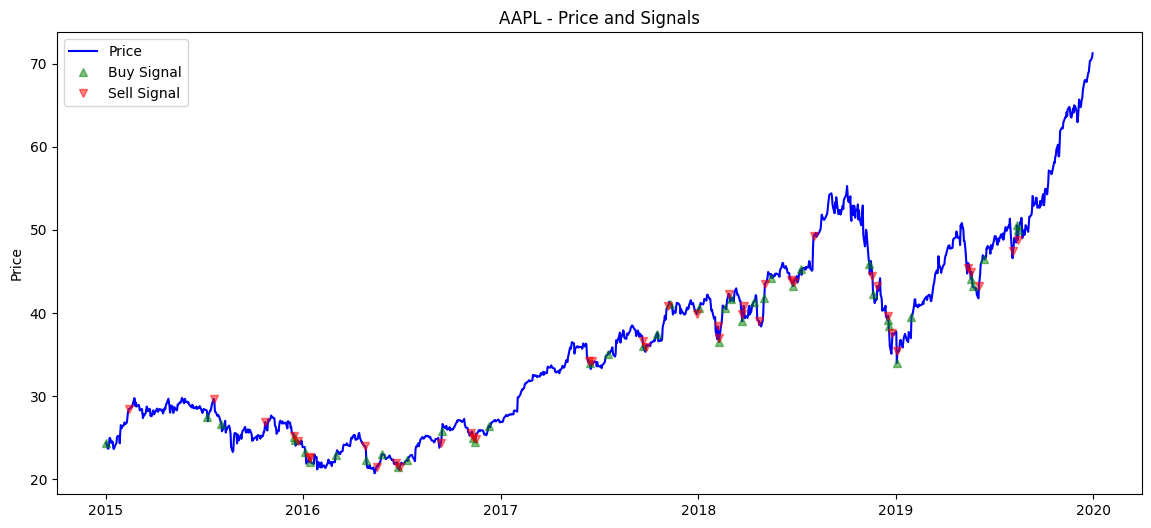

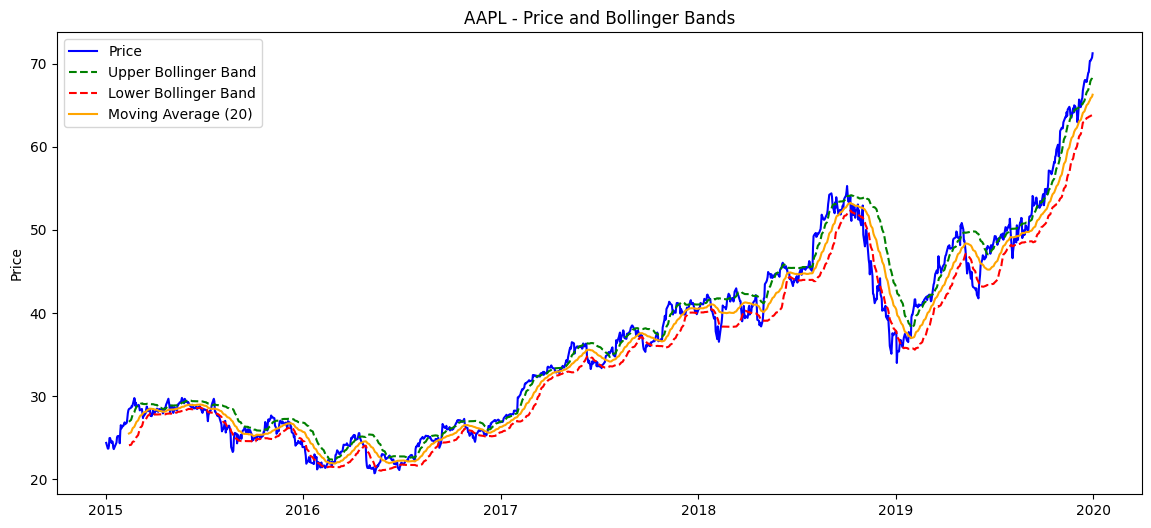

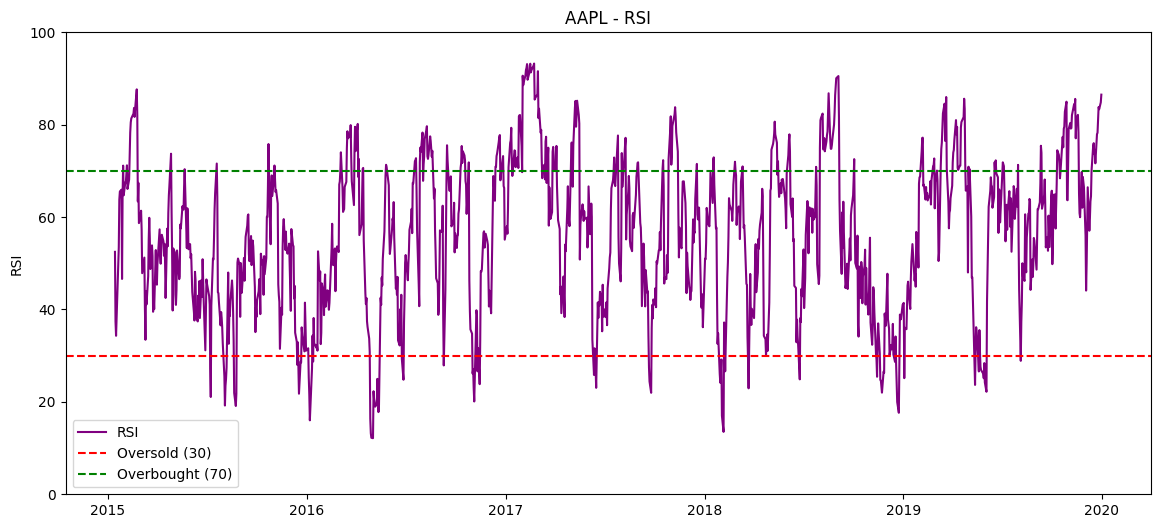

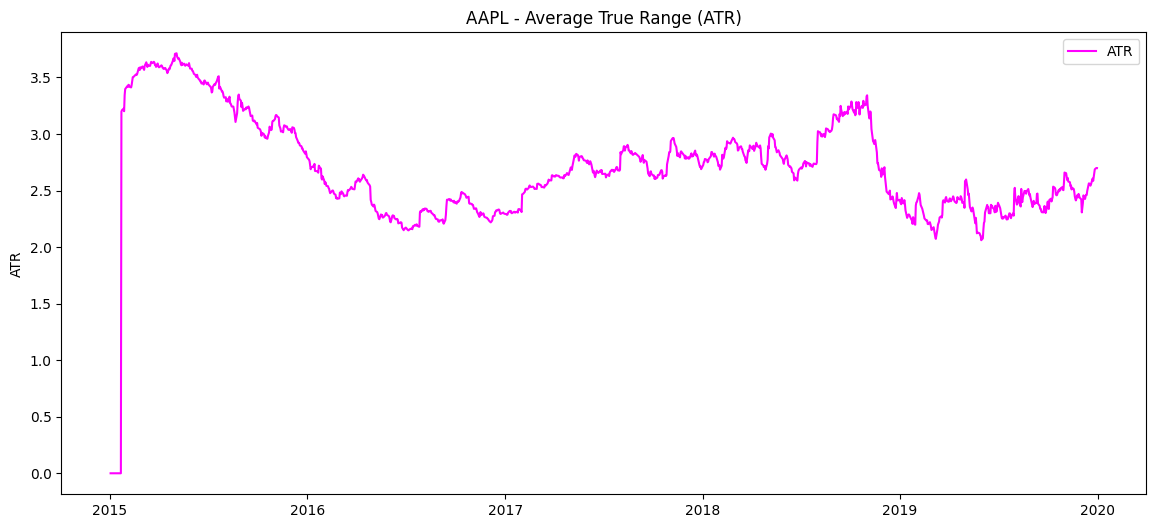

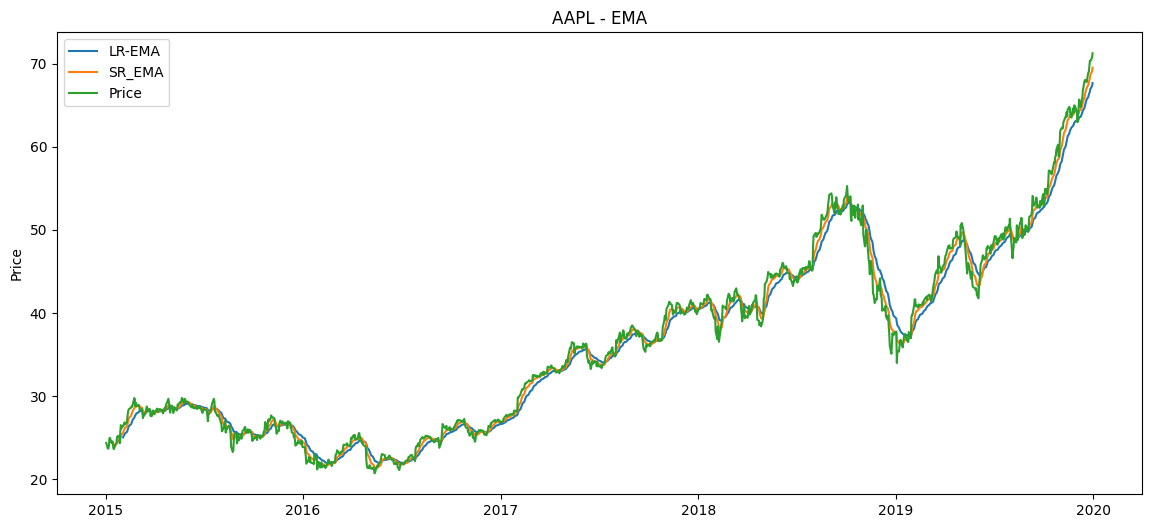

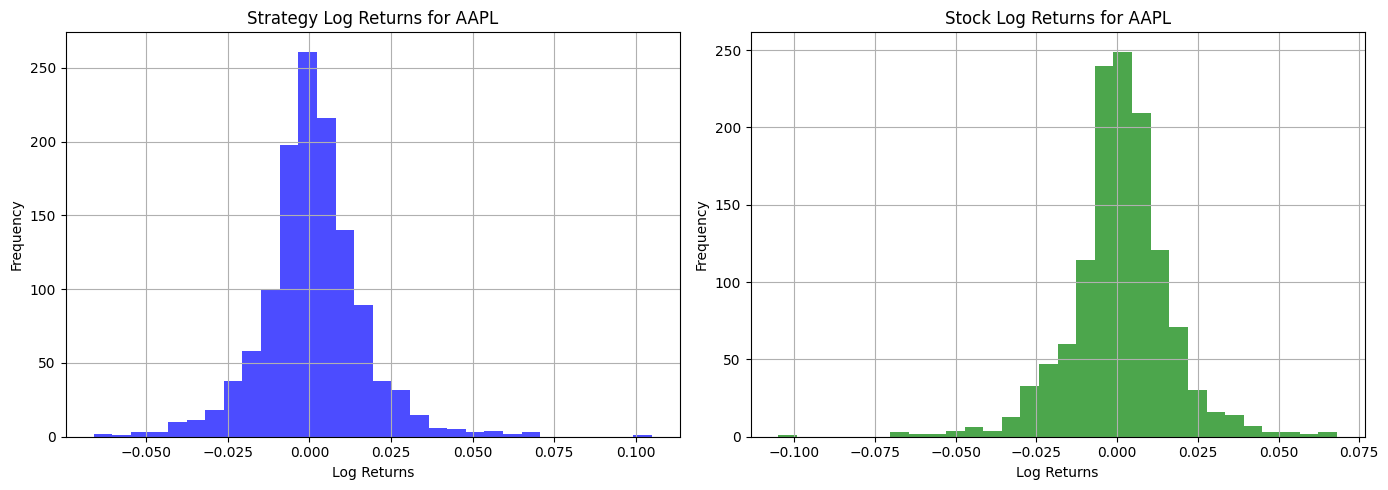

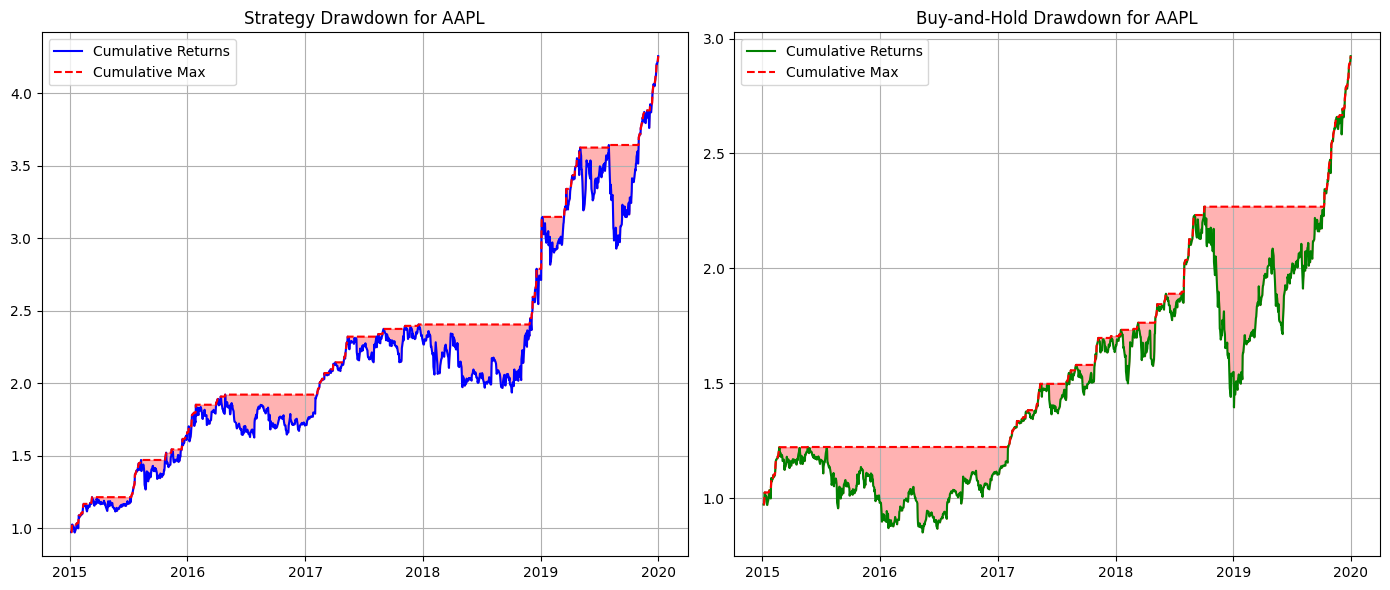

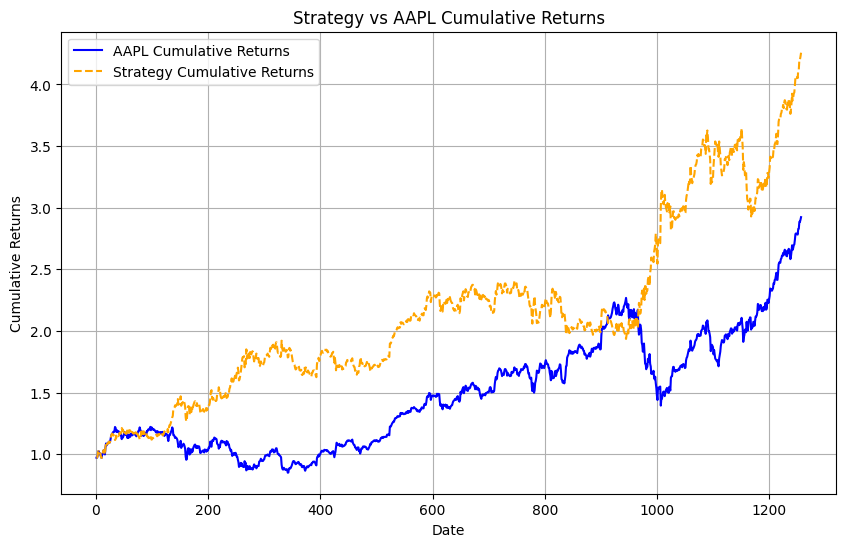

In [420]:
overall_individual_stock_metrics = pd.DataFrame()
# Stock Level Analysis
for index in indices:
    strategy2 = Strategy2(stock_symbol=index, start_date=start, end_date=end, bb_window=best_bb_window, bb_sd=best_bb_sd, rsi_window=best_rsi_window, atr_window=best_atr_window, ema_lr_window=best_ema_lr_window, ema_sr_window=best_ema_sr_window)
    strategy2.run_strategy()
    strategy2.plot_all_charts()
#     metrics = strategy2.calculate_stock_metrics()
#     overall_individual_stock_metrics = pd.concat([overall_individual_stock_metrics, metrics])
# overall_individual_stock_metrics

# Strategy 2 Analysis
1. Analysis done in metrics. 
2. Strategy 2's performance compared to a buy-and-hold strategy.
3. Portfolio used to measure performance is an equal-weighted MAANG portfolio.

### Metrics Used
1. Average Annualized Returns
2. Alpha
3. Beta
4. Standard Deviation
5. Sharpe Ratio
6. Max Drawdown
7. Sortino Ratio
8. Information Ratio
9. Calmar Ratio
10. Treynor Ratio


### Calculate Cumulative Returns of Buy-and-Hold Strategy

In [421]:
# Calculate Returns of Strategy 
strat_df = pd.DataFrame()

for index in indices:
    # Initialize and run the strategy for each stock
    strategy2 = Strategy2(stock_symbol=index, start_date=start, end_date=end, bb_window=best_bb_window, bb_sd=best_bb_sd, rsi_window=best_rsi_window, atr_window=best_atr_window, ema_lr_window=best_ema_lr_window, ema_sr_window=best_ema_sr_window)
    strategy2.run_strategy()

    if strat_df.empty:
        strat_df = strategy2.stock_data[['Date', f'{index}_Strategy_Returns']]
    else:
        strat_df = pd.merge(strat_df, strategy2.stock_data[['Date', f'{index}_Strategy_Returns']], on='Date', how='inner')

daily_index_return_columns = [col for col in strat_df.columns if '_Strategy_Returns' in col]
strat_df = strat_df.copy()
strat_df['Strat_Returns'] = strat_df[daily_index_return_columns].mean(axis=1)

# Calculate Returns of Buy-and-Hold Strategy
buyhold_df = pd.DataFrame()

for stock in indices:
    ticker_data = yf.download(stock, start, end).reset_index()
    ticker_data[f'{stock}_Returns'] = ticker_data['Adj Close'].pct_change()

    if buyhold_df.empty:
        buyhold_df = ticker_data[['Date', f'{stock}_Returns']]
    else:
        # Merge cumulative Buy-and-Hold returns for other stocks
        buyhold_df = pd.merge(buyhold_df, ticker_data[['Date', f'{stock}_Returns']], on='Date', how='inner')

daily_index_return_columns = [col for col in buyhold_df.columns if '_Returns' in col]
buyhold_df = buyhold_df.copy()
buyhold_df['BuyHold_Returns'] = buyhold_df[daily_index_return_columns].mean(axis=1)

# Calculate Cumulative Returns for Strategy
# Step 1: Calculate log returns for the stock 
strat_df['Log_Return'] = np.log(1 + strat_df['Strat_Returns'])
# Step 2: Calculate the cumulative log returns
strat_df['Cumulative_Log_Return'] = strat_df['Log_Return'].cumsum()
# Step 3: Convert cumulative log returns to cumulative linear returns
strat_df['Cumulative_Linear_Return'] = np.exp(strat_df['Cumulative_Log_Return']) 

# Calculate Cumulative Returns for Buy-and-Hold Strategy
# Step 1: Calculate log returns for the stock 
buyhold_df['Log_Return'] = np.log(1 + buyhold_df['BuyHold_Returns'])
# Step 2: Calculate the cumulative log returns
buyhold_df['Cumulative_Log_Return'] = buyhold_df['Log_Return'].cumsum()
# Step 3: Convert cumulative log returns to cumulative linear returns
buyhold_df['Cumulative_Linear_Return'] = np.exp(buyhold_df['Cumulative_Log_Return']) 

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


### Performance Analysis - Metrics
#### Strategy 2 vs Buy-and-Hold Strategy (In-Sample)

In [422]:
def calculate_benchmark_returns():
    # Download the SPY data
    benchmark_data = yf.download('SPY', start=start, end=end).reset_index()

    # Calculate daily percentage returns for SPY
    benchmark_data['SPY_Returns'] = benchmark_data['Adj Close'].pct_change()

    # Convert percentage returns to log returns (for use in calculations)
    benchmark_data['Log_SPY_Returns'] = np.log1p(benchmark_data['SPY_Returns'])

    # Return only the daily log returns for further analysis
    return benchmark_data['SPY_Returns']

# Risk Free Rate assumed to be 0
risk_free_rate = 0

# Daily log returns of the stock
buyhold_returns = buyhold_df['BuyHold_Returns']
strategy_returns = strat_df['Strat_Returns']
benchmark_returns = calculate_benchmark_returns()

# Remove NaN values
merged_data = pd.DataFrame({
    'buyhold_returns': buyhold_returns,
    'strategy_returns': strategy_returns,
    'benchmark_returns': benchmark_returns
}).dropna()

# Calculate Beta
covariance_buyhold = np.cov(merged_data['buyhold_returns'], merged_data['benchmark_returns'])[0, 1]
variance_buyhold = np.var(merged_data['benchmark_returns'])
beta_buyhold = covariance_buyhold / variance_buyhold if variance_buyhold != 0 else np.nan

covariance_strat = np.cov(merged_data['strategy_returns'], merged_data['benchmark_returns'])[0, 1]
variance_strat = np.var(merged_data['benchmark_returns'])
beta_strat = covariance_strat / variance_strat if variance_strat != 0 else np.nan

# Calculate Alpha
buyhold_yearly_return = merged_data['buyhold_returns'].mean() * 252
strat_yearly_return = merged_data['strategy_returns'].mean() * 252
benchmark_yearly_return = merged_data['benchmark_returns'].mean() * 252
alpha_buyhold = (buyhold_yearly_return - risk_free_rate - beta_buyhold * (benchmark_yearly_return - risk_free_rate))
alpha_strat = (strat_yearly_return - risk_free_rate - beta_strat * (benchmark_yearly_return - risk_free_rate))

# Calculate Standard Deviation
buyhold_daily_sd = merged_data['buyhold_returns'].std()
strat_daily_sd = merged_data['strategy_returns'].std()
std_dev_strat = strat_daily_sd * np.sqrt(252)  # Annualized standard deviation for Strategy
std_dev_buyhold = buyhold_daily_sd * np.sqrt(252)  # Annualized standard deviation for Buy-and-Hold

# Calculate Sharpe Ratio
daily_SR_buyhold = (merged_data['buyhold_returns'].mean() - risk_free_rate) / buyhold_daily_sd
daily_SR_strat = (merged_data['strategy_returns'].mean() - risk_free_rate) / strat_daily_sd
annual_SR_buyhold = daily_SR_buyhold * np.sqrt(252)
annual_SR_strat = daily_SR_strat * np.sqrt(252)

# Calculate Maximum Drawdown
cumulative_returns_strat = (1 + merged_data['strategy_returns']).cumprod()
cum_max_strat = cumulative_returns_strat.cummax()
drawdown_strat = cum_max_strat - cumulative_returns_strat
max_drawdown_strat = drawdown_strat.max()

cumulative_returns_buyhold = (1 + merged_data['buyhold_returns']).cumprod()
cum_max_buyhold = cumulative_returns_buyhold.cummax()
drawdown_buyhold = cum_max_buyhold - cumulative_returns_buyhold
max_drawdown_buyhold = drawdown_buyhold.max()

# Calculate Sortino Ratio
converted_returns_strat = merged_data['strategy_returns'].apply(lambda x: 0 if x > 0 else x)
squared_converted_returns_strat = converted_returns_strat ** 2
squared_sum_converted_returns_strat = np.sum(squared_converted_returns_strat)
downside_deviation_strat = np.sqrt(squared_sum_converted_returns_strat / len(converted_returns_strat))
annual_converted_sd_strat = downside_deviation_strat * np.sqrt(252)
sortino_ratio_strat = (strat_yearly_return) / annual_converted_sd_strat

converted_returns_buyhold = merged_data['buyhold_returns'].apply(lambda x: 0 if x > 0 else x)
squared_converted_returns_buyhold = converted_returns_buyhold ** 2
squared_sum_converted_returns_buyhold = np.sum(squared_converted_returns_buyhold)
downside_deviation_buyhold = np.sqrt(squared_sum_converted_returns_buyhold / len(converted_returns_buyhold))
annual_converted_sd_buyhold = downside_deviation_buyhold * np.sqrt(252)
sortino_ratio_buyhold = (buyhold_yearly_return) / annual_converted_sd_buyhold

# Calculate Calmar Ratio
calmar_ratio_strat = strat_yearly_return / max_drawdown_strat
calmar_ratio_buyhold = buyhold_yearly_return / max_drawdown_buyhold

# Calculate Treynor Ratio
treynor_ratio_strat = (strat_yearly_return - risk_free_rate) / beta_strat
treynor_ratio_buyhold = (buyhold_yearly_return - risk_free_rate) / beta_buyhold

# Calculate Tracking Error 
tracking_error_strat = np.std(merged_data['strategy_returns'] - merged_data['benchmark_returns']) * np.sqrt(252)
tracking_error_buyhold = np.std(merged_data['buyhold_returns'] - merged_data['benchmark_returns']) * np.sqrt(252)

# Calculate Information Ratio
information_ratio_strat = (strat_yearly_return - benchmark_yearly_return) / tracking_error_strat
information_ratio_buyhold = (buyhold_yearly_return - benchmark_yearly_return) / tracking_error_buyhold

# Create a DataFrame to store the metrics
metrics_dict = {
    'Metric': [
        'Returns', 'Alpha', 'Beta', 'SD', 'Sharpe Ratio', 
        'Max Drawdown', 'Sortino Ratio', 'Calmar Ratio', 
        'Treynor Ratio', 'Information Ratio'
    ],
    'Buy-and-Hold': [
        buyhold_yearly_return, alpha_buyhold, beta_buyhold, std_dev_buyhold, annual_SR_buyhold,
        max_drawdown_buyhold, sortino_ratio_buyhold, calmar_ratio_buyhold, 
        treynor_ratio_buyhold, information_ratio_buyhold
    ],
    'Strat': [
        strat_yearly_return, alpha_strat, beta_strat, std_dev_strat, annual_SR_strat,
        max_drawdown_strat, sortino_ratio_strat, calmar_ratio_strat, 
        treynor_ratio_strat, information_ratio_strat
    ]
}

metrics_df = pd.DataFrame(metrics_dict).set_index('Metric')
metrics_df.T

[*********************100%%**********************]  1 of 1 completed

Metric,Returns,Alpha,Beta,SD,Sharpe Ratio,Max Drawdown,Sortino Ratio,Calmar Ratio,Treynor Ratio,Information Ratio
Buy-and-Hold,0.246032,0.098398,1.242527,0.248374,0.990570,0.873577,1.432638,0.281637,0.198009,0.680744
Strat,0.295014,0.273311,0.182656,0.248162,1.188795,0.637250,1.831037,0.462949,1.615138,0.652245


## Running the Strategy (Out-of-Sample)
With the best parameters identified, the strategy is applied to the AAPL stocks. The performance is visualized, and metrics are calculated for each stock.

[*********************100%%**********************]  1 of 1 completed


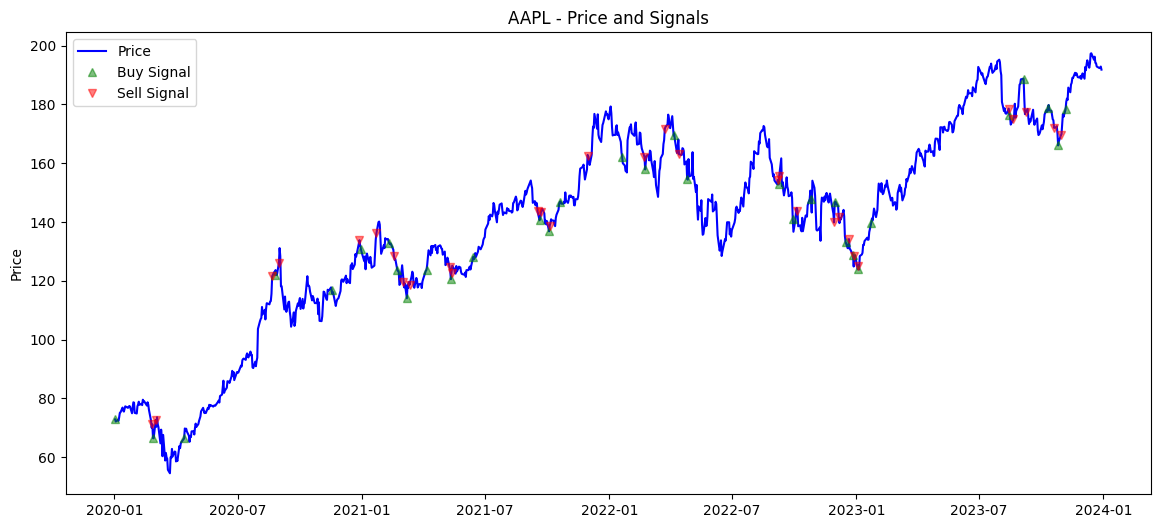

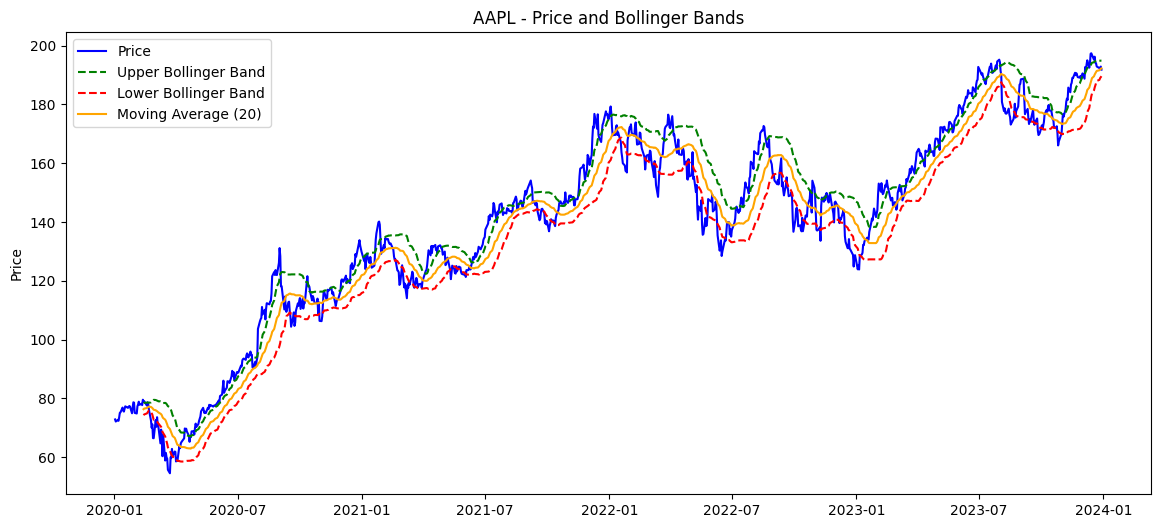

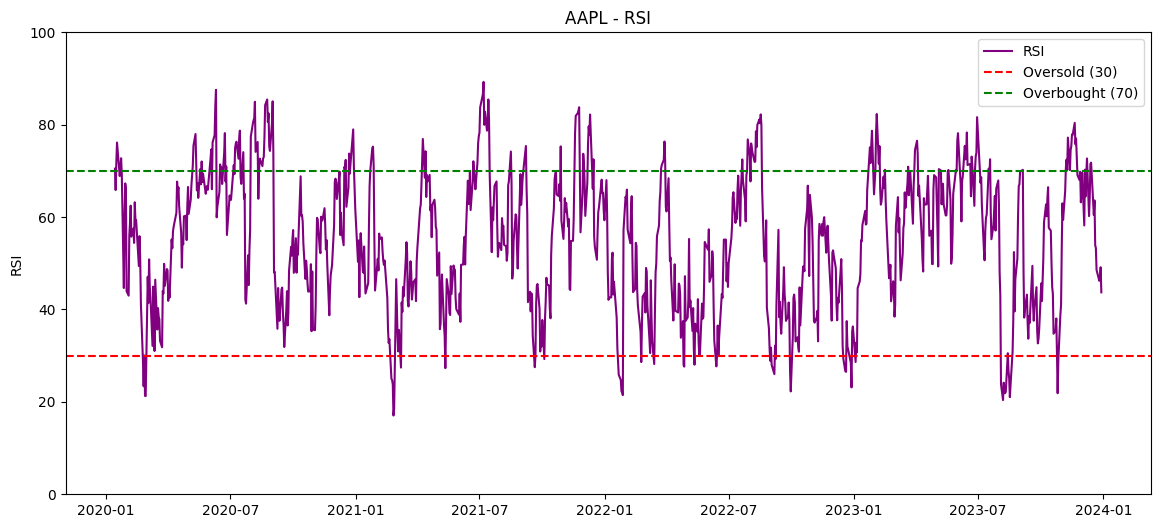

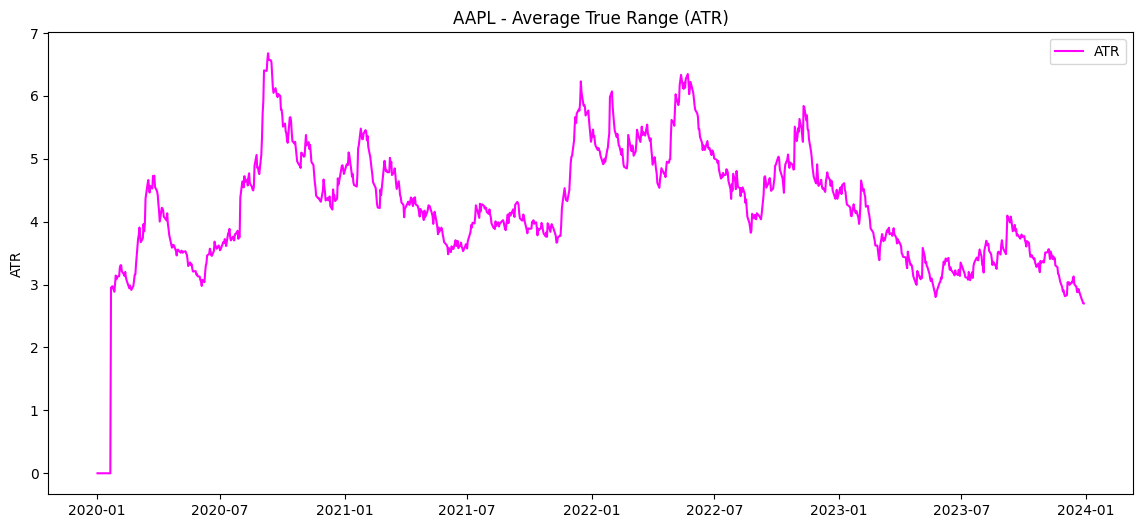

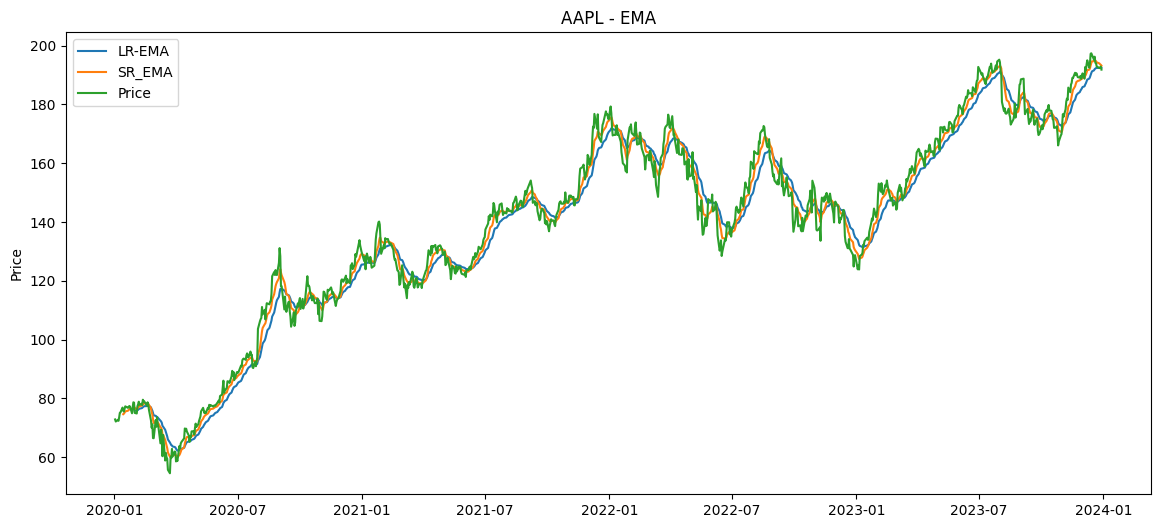

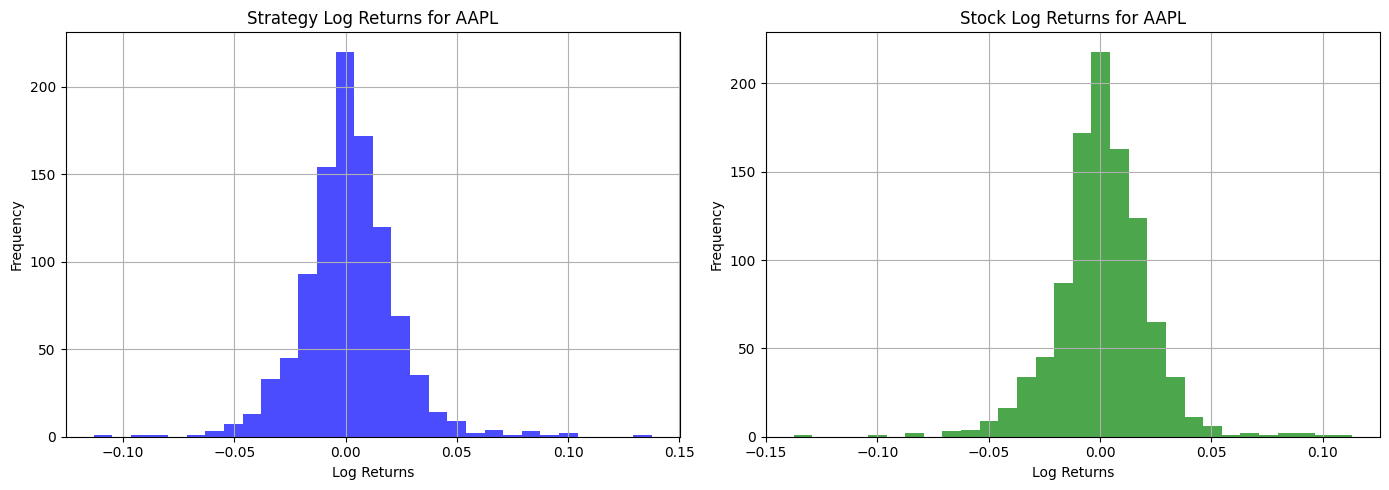

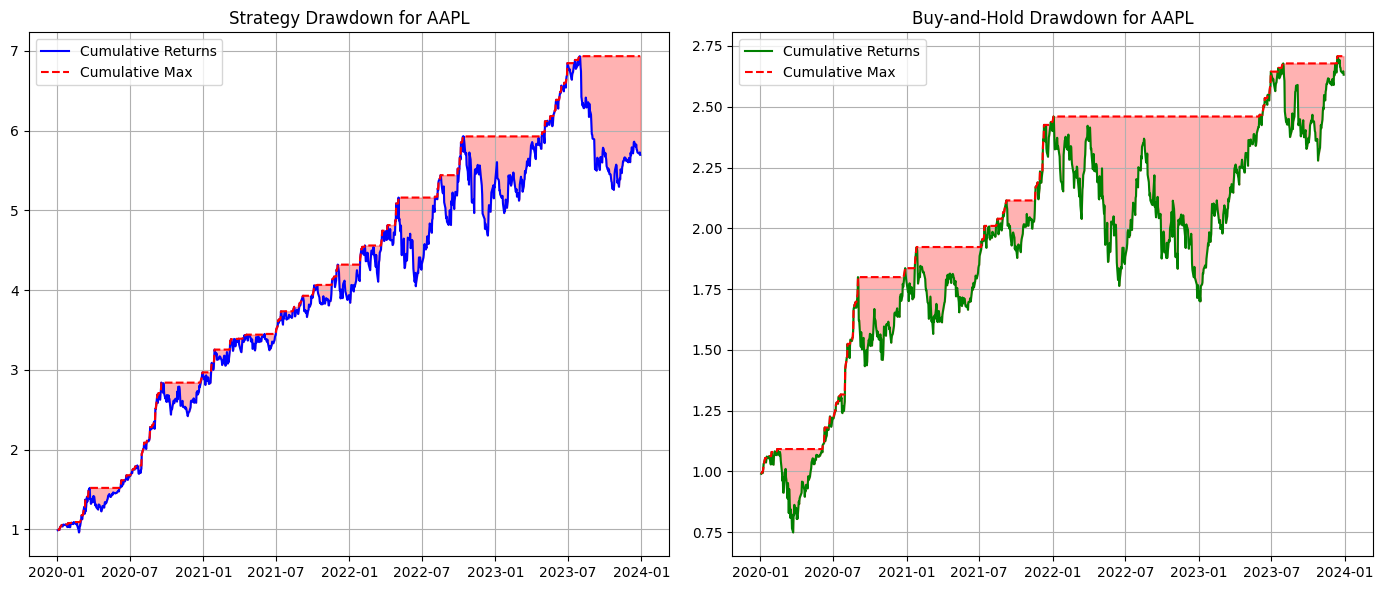

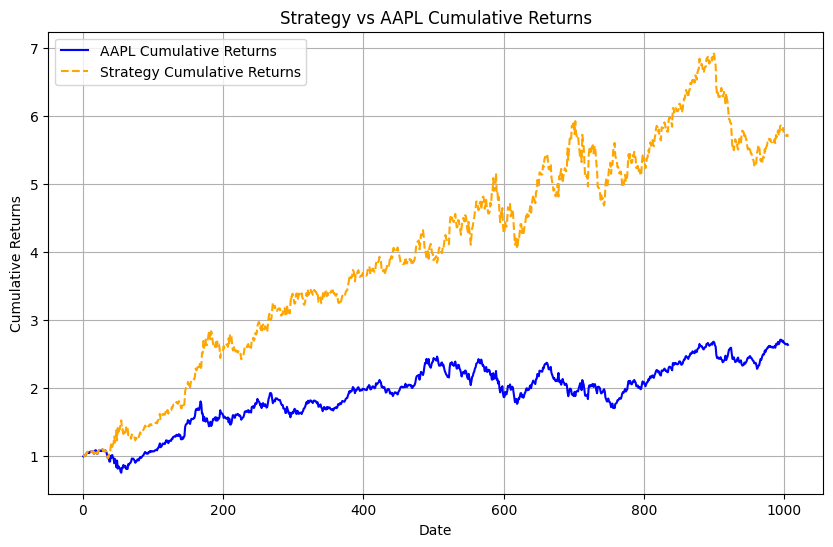

In [423]:
overall_individual_stock_metrics = pd.DataFrame()
start = '2020-01-01'
end = '2024-01-01'
# Stock Level Analysis
for index in indices:
    strategy2 = Strategy2(stock_symbol=index, start_date=start, end_date=end, bb_window=best_bb_window, bb_sd=best_bb_sd, rsi_window=best_rsi_window, atr_window=best_atr_window, ema_lr_window=best_ema_lr_window, ema_sr_window=best_ema_sr_window)
    strategy2.run_strategy()
    strategy2.plot_all_charts()
#     metrics = strategy2.calculate_stock_metrics()
#     overall_individual_stock_metrics = pd.concat([overall_individual_stock_metrics, metrics])
# overall_individual_stock_metrics

### Calculate cumulative returns

In [424]:
# Calculate Returns of Strategy 
strat_df = pd.DataFrame()

for index in indices:
    # Initialize and run the strategy for each stock
    strategy2 = Strategy2(stock_symbol=index, start_date=start, end_date=end, bb_window=best_bb_window, bb_sd=best_bb_sd, rsi_window=best_rsi_window, atr_window=best_atr_window, ema_lr_window=best_ema_lr_window, ema_sr_window=best_ema_sr_window)
    strategy2.run_strategy()

    if strat_df.empty:
        strat_df = strategy2.stock_data[['Date', f'{index}_Strategy_Returns']]
    else:
        strat_df = pd.merge(strat_df, strategy2.stock_data[['Date', f'{index}_Strategy_Returns']], on='Date', how='inner')

daily_index_return_columns = [col for col in strat_df.columns if '_Strategy_Returns' in col]
strat_df = strat_df.copy()
strat_df['Strat_Returns'] = strat_df[daily_index_return_columns].mean(axis=1)

# Calculate Returns of Buy-and-Hold Strategy
buyhold_df = pd.DataFrame()

for stock in indices:
    ticker_data = yf.download(stock, start, end).reset_index()
    ticker_data[f'{stock}_Returns'] = ticker_data['Adj Close'].pct_change()

    if buyhold_df.empty:
        buyhold_df = ticker_data[['Date', f'{stock}_Returns']]
    else:
        # Merge cumulative Buy-and-Hold returns for other stocks
        buyhold_df = pd.merge(buyhold_df, ticker_data[['Date', f'{stock}_Returns']], on='Date', how='inner')

daily_index_return_columns = [col for col in buyhold_df.columns if '_Returns' in col]
buyhold_df = buyhold_df.copy()
buyhold_df['BuyHold_Returns'] = buyhold_df[daily_index_return_columns].mean(axis=1)

# Calculate Cumulative Returns for Strategy
# Step 1: Calculate log returns for the stock 
strat_df['Log_Return'] = np.log(1 + strat_df['Strat_Returns'])
# Step 2: Calculate the cumulative log returns
strat_df['Cumulative_Log_Return'] = strat_df['Log_Return'].cumsum()
# Step 3: Convert cumulative log returns to cumulative linear returns
strat_df['Cumulative_Linear_Return'] = np.exp(strat_df['Cumulative_Log_Return']) 

# Calculate Cumulative Returns for Buy-and-Hold Strategy
# Step 1: Calculate log returns for the stock 
buyhold_df['Log_Return'] = np.log(1 + buyhold_df['BuyHold_Returns'])
# Step 2: Calculate the cumulative log returns
buyhold_df['Cumulative_Log_Return'] = buyhold_df['Log_Return'].cumsum()
# Step 3: Convert cumulative log returns to cumulative linear returns
buyhold_df['Cumulative_Linear_Return'] = np.exp(buyhold_df['Cumulative_Log_Return']) 

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


### Performance Analysis - Metrics
#### Strategy 2 vs Buy-and-Hold Strategy (Out-of-Sample) 

In [425]:
def calculate_benchmark_returns():
    # Download the SPY data
    benchmark_data = yf.download('SPY', start=start, end=end).reset_index()

    # Calculate daily percentage returns for SPY
    benchmark_data['SPY_Returns'] = benchmark_data['Adj Close'].pct_change()

    # Convert percentage returns to log returns (for use in calculations)
    benchmark_data['Log_SPY_Returns'] = np.log1p(benchmark_data['SPY_Returns'])

    # Return only the daily log returns for further analysis
    return benchmark_data['SPY_Returns']

# Risk Free Rate assumed to be 0
risk_free_rate = 0

# Daily log returns of the stock
buyhold_returns = buyhold_df['BuyHold_Returns']
strategy_returns = strat_df['Strat_Returns']
benchmark_returns = calculate_benchmark_returns()

# Remove NaN values
merged_data = pd.DataFrame({
    'buyhold_returns': buyhold_returns,
    'strategy_returns': strategy_returns,
    'benchmark_returns': benchmark_returns
}).dropna()

# Calculate Beta
covariance_buyhold = np.cov(merged_data['buyhold_returns'], merged_data['benchmark_returns'])[0, 1]
variance_buyhold = np.var(merged_data['benchmark_returns'])
beta_buyhold = covariance_buyhold / variance_buyhold if variance_buyhold != 0 else np.nan

covariance_strat = np.cov(merged_data['strategy_returns'], merged_data['benchmark_returns'])[0, 1]
variance_strat = np.var(merged_data['benchmark_returns'])
beta_strat = covariance_strat / variance_strat if variance_strat != 0 else np.nan

# Calculate Alpha
buyhold_yearly_return = merged_data['buyhold_returns'].mean() * 252
strat_yearly_return = merged_data['strategy_returns'].mean() * 252
benchmark_yearly_return = merged_data['benchmark_returns'].mean() * 252
alpha_buyhold = (buyhold_yearly_return - risk_free_rate - beta_buyhold * (benchmark_yearly_return - risk_free_rate))
alpha_strat = (strat_yearly_return - risk_free_rate - beta_strat * (benchmark_yearly_return - risk_free_rate))

# Calculate Standard Deviation
buyhold_daily_sd = merged_data['buyhold_returns'].std()
strat_daily_sd = merged_data['strategy_returns'].std()
std_dev_strat = strat_daily_sd * np.sqrt(252)  # Annualized standard deviation for Strategy
std_dev_buyhold = buyhold_daily_sd * np.sqrt(252)  # Annualized standard deviation for Buy-and-Hold

# Calculate Sharpe Ratio
daily_SR_buyhold = (merged_data['buyhold_returns'].mean() - risk_free_rate) / buyhold_daily_sd
daily_SR_strat = (merged_data['strategy_returns'].mean() - risk_free_rate) / strat_daily_sd
annual_SR_buyhold = daily_SR_buyhold * np.sqrt(252)
annual_SR_strat = daily_SR_strat * np.sqrt(252)

# Calculate Maximum Drawdown
cumulative_returns_strat = (1 + merged_data['strategy_returns']).cumprod()
cum_max_strat = cumulative_returns_strat.cummax()
drawdown_strat = cum_max_strat - cumulative_returns_strat
max_drawdown_strat = drawdown_strat.max()

cumulative_returns_buyhold = (1 + merged_data['buyhold_returns']).cumprod()
cum_max_buyhold = cumulative_returns_buyhold.cummax()
drawdown_buyhold = cum_max_buyhold - cumulative_returns_buyhold
max_drawdown_buyhold = drawdown_buyhold.max()

# Calculate Sortino Ratio
converted_returns_strat = merged_data['strategy_returns'].apply(lambda x: 0 if x > 0 else x)
squared_converted_returns_strat = converted_returns_strat ** 2
squared_sum_converted_returns_strat = np.sum(squared_converted_returns_strat)
downside_deviation_strat = np.sqrt(squared_sum_converted_returns_strat / len(converted_returns_strat))
annual_converted_sd_strat = downside_deviation_strat * np.sqrt(252)
sortino_ratio_strat = (strat_yearly_return) / annual_converted_sd_strat

converted_returns_buyhold = merged_data['buyhold_returns'].apply(lambda x: 0 if x > 0 else x)
squared_converted_returns_buyhold = converted_returns_buyhold ** 2
squared_sum_converted_returns_buyhold = np.sum(squared_converted_returns_buyhold)
downside_deviation_buyhold = np.sqrt(squared_sum_converted_returns_buyhold / len(converted_returns_buyhold))
annual_converted_sd_buyhold = downside_deviation_buyhold * np.sqrt(252)
sortino_ratio_buyhold = (buyhold_yearly_return) / annual_converted_sd_buyhold

# Calculate Calmar Ratio
calmar_ratio_strat = strat_yearly_return / max_drawdown_strat
calmar_ratio_buyhold = buyhold_yearly_return / max_drawdown_buyhold

# Calculate Treynor Ratio
treynor_ratio_strat = (strat_yearly_return - risk_free_rate) / beta_strat
treynor_ratio_buyhold = (buyhold_yearly_return - risk_free_rate) / beta_buyhold

# Calculate Tracking Error 
tracking_error_strat = np.std(merged_data['strategy_returns'] - merged_data['benchmark_returns']) * np.sqrt(252)
tracking_error_buyhold = np.std(merged_data['buyhold_returns'] - merged_data['benchmark_returns']) * np.sqrt(252)

# Calculate Information Ratio
information_ratio_strat = (strat_yearly_return - benchmark_yearly_return) / tracking_error_strat
information_ratio_buyhold = (buyhold_yearly_return - benchmark_yearly_return) / tracking_error_buyhold

# Create a DataFrame to store the metrics
metrics_dict = {
    'Metric': [
        'Returns', 'Alpha', 'Beta', 'SD', 'Sharpe Ratio', 
        'Max Drawdown', 'Sortino Ratio', 'Calmar Ratio', 
        'Treynor Ratio', 'Information Ratio'
    ],
    'Buy-and-Hold': [
        buyhold_yearly_return, alpha_buyhold, beta_buyhold, std_dev_buyhold, annual_SR_buyhold,
        max_drawdown_buyhold, sortino_ratio_buyhold, calmar_ratio_buyhold, 
        treynor_ratio_buyhold, information_ratio_buyhold
    ],
    'Strat': [
        strat_yearly_return, alpha_strat, beta_strat, std_dev_strat, annual_SR_strat,
        max_drawdown_strat, sortino_ratio_strat, calmar_ratio_strat, 
        treynor_ratio_strat, information_ratio_strat
    ]
}

metrics_df = pd.DataFrame(metrics_dict).set_index('Metric')
metrics_df.T

[*********************100%%**********************]  1 of 1 completed


Metric,Returns,Alpha,Beta,SD,Sharpe Ratio,Max Drawdown,Sortino Ratio,Calmar Ratio,Treynor Ratio,Information Ratio
Buy-and-Hold,0.299015,0.133116,1.211485,0.335681,0.890771,0.760448,1.316005,0.393209,0.246817,0.811276
Strat,0.439397,0.456566,-0.125375,0.335067,1.311370,1.390789,2.029370,0.315934,-3.504663,0.720715
